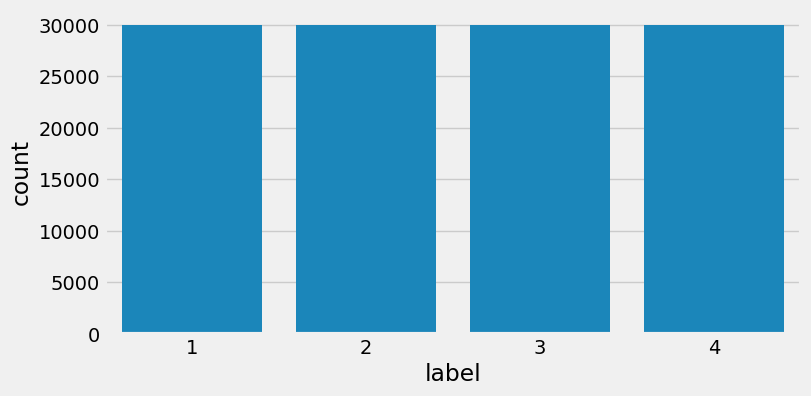

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB
NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


'Carlyle Looks Toward Commercial Aerospace ReutersReuters   Private investment firm Carlyle Group reputation making well timed occasionally controversial plays defense industry quietly placed bets another part market'

In [ ]:
# Install important dependencies
!pip install transformers nltk datasets numpy seaborn pandas scikit-learn matplotlib

# Import Dependencies
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# To import the Transformer Models
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# to convert to Dataset datatype - the transformers library does not work well with pandas
from datasets import Dataset

# The dataset does not contain class labels, so we need to explicitly provide it
df=pd.read_csv("/content/train.csv")
df.head()

df = df.rename(columns={'Class Index':'label'})
df.head()

# checking for unbalanced dataset
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,4))
sns.countplot(x=df['label'])
plt.show()

# data informations
df.info()

# data preprocessing

# concatinating the 'title' and 'description' column
df['text']=(df['Title']+df['Description'])
df.drop(columns=['Title','Description'],axis=1,inplace=True)
df.head()

# Text before preprocessing - contains symbols like ()\-,.' which is not useful

df['text'][1]

# remove punctuations

import re   # regular expression can be used to remove any punctuation or unnecessary symbols

def remove_punctuations(text):
     text=re.sub(r'[\\-]',' ',text)
     text=re.sub(r'[,.?;:\'(){}!|0-9]','',text)
     return text

# the apply method applies a function along an axis of dataframe

df['text']=df['text'].apply(remove_punctuations)
df.head()

import nltk

# downloading corpus only would work

nltk.download() #you need to download the stopwords library only for this project

# import stopWords

from nltk.corpus import stopwords

# english stopwords

stopw=stopwords.words('english')
stopw[:10]

def remove_stopwords(text):
    clean_text=[]
    for word in text.split(' '):
        if word not in stopw:
            clean_text.append(word)
    return ' '.join(clean_text)

# remove stopwords

df['text']=df['text'].apply(remove_stopwords)

# the class label in dataset contains labels as 1,2,3,4 but the model needs 0,1,2,3, so we subtract 1 from all

df['label']=df['label'].apply(lambda x:x-1)
df.head()

df['text'][1]   # this is the final preprocessed text

In [ ]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split

# since training on the full dataset(120,000 samples) would be take so long, the train size is only taken to be 30%
train_df,test_df=train_test_split(df[['text','label']],train_size=.3,shuffle=True)
test_df=test_df[:10000]

train_df.shape,test_df.shape    # training set has 36000 samples and testing set has 10000 samples

# load a pre-built tokenizer and convert to tokens
# load tokenizer from bert base uncased model available from huggingface.co
model_name='bert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

def pipeline(dataframe):
    # This step isn't mentioned anywhere but is vital as Transformers library only seems to work with this Dataset data type
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('text')
    return tokenized_ds

# create pipeline for training data and testing data
tokenized_train = pipeline(train_df)
tokenized_test = pipeline(test_df)

# Load a pre-trained model
# Adjust Model training arguments

# load bert-based-uncased model for fine tuning
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

# adjust the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy = 'epoch',
    optim='adamw_torch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
)

from transformers import TrainerCallback
import pandas as pd

#for saving the loss funcation values
class LossRecorderCallback(TrainerCallback):
    def __init__(self):
        self.logs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            self.logs.append({
                "step": state.global_step,
                "loss": logs["loss"]
            })

loss_callback = LossRecorderCallback()

# create the trainer from Trainer class in transformer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[loss_callback],
)

# model training
trainer.train()

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-21-3016543067.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.406600
1000,0.301700
1500,0.277700
2000,0.267800
2500,0.220800
3000,0.187200
3500,0.202100
4000,0.190500
4500,0.189100
5000,0.124700


TrainOutput(global_step=9000, training_loss=0.17503278223673502, metrics={'train_runtime': 1860.0093, 'train_samples_per_second': 77.419, 'train_steps_per_second': 4.839, 'total_flos': 4716227022698880.0, 'train_loss': 0.17503278223673502, 'epoch': 4.0})

In [ ]:
# Optional

"""# 1. Install TensorBoard (if not already installed)
%pip install tensorboard

# 2. Load TensorBoard
%load_ext tensorboard

# 3. Launch TensorBoard and point it to the folder containing your .tfevents file
%tensorboard --logdir=/content/results/runs/Jul09_11-49-29_a9de50b90bdf/events.out.tfevents.1752061772.a9de50b90bdf.1738.0


In [ ]:
# Convert Loss to DataFrame
loss_df = pd.DataFrame(loss_callback.logs)

# Save to CSV
loss_df.to_csv("loss.csv", index=False) #will be save in content folder in Colab

In [ ]:
loss_df.head(20)

,step,loss
0,500,0.4066
1,1000,0.3017
2,1500,0.2777
3,2000,0.2678
4,2500,0.2208
5,3000,0.1872
6,3500,0.2021
7,4000,0.1905
8,4500,0.1891
9,5000,0.1247


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['step'].plot(kind='hist', bins=20, title='step')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['loss'].plot(kind='hist', bins=20, title='loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='step', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='step', y='loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['step']
  ys = series['loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('step', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('step')
_ = plt.ylabel('loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['step']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'step'}, axis=1)
              .sort_values('step', ascending=True))
  xs = counted['step']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('step', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('step')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['step'].plot(kind='line', figsize=(8, 4), title='step')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['loss'].plot(kind='line', figsize=(8, 4), title='loss')
plt.gca().spines[['top', 'right']].set_visible(False)

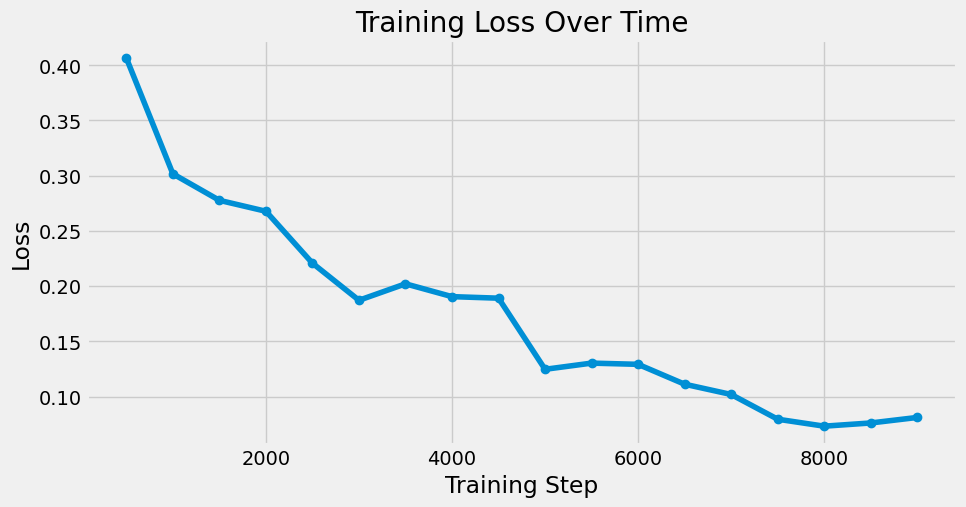

In [ ]:
#plotting loss function

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_df["step"], loss_df["loss"], marker='o')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.show()

**Model Evaluation**

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2465
           1       0.98      0.98      0.98      2549
           2       0.90      0.90      0.90      2471
           3       0.90      0.92      0.91      2515

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



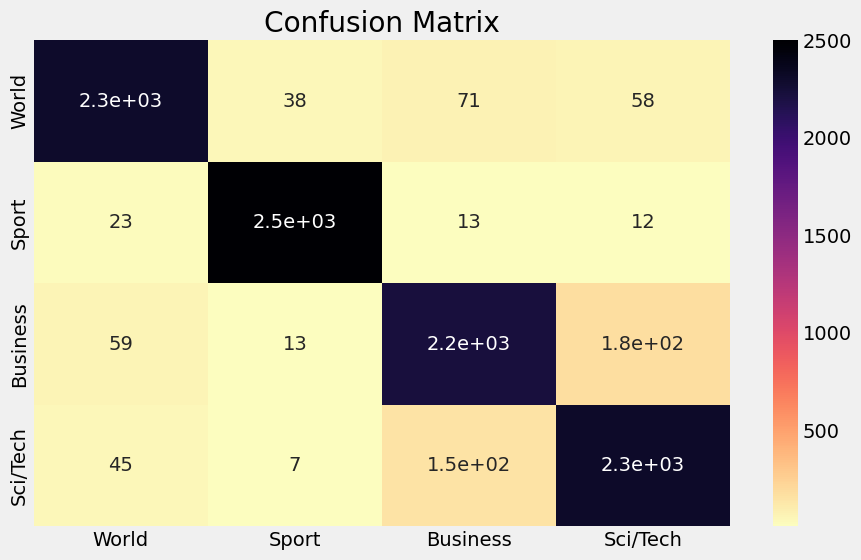

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       1.00      1.00      1.00        26
           2       0.96      1.00      0.98        24
           3       0.94      0.94      0.94        18

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Prediction	Actual
----------------------
Sports  --->  Sports
Sports  --->  Sports
World  --->  World
Sports  --->  Sports
Sci/Tech  --->  Sci/Tech
World  --->  World
Business  --->  Business
World  --->  World
Sports  --->  Sports
Business  --->  Business


/tmp/ipython-input-24-2468664407.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Evaluate the Model

# create tokenized text for test dataset
tokenized_test = pipeline(test_df)
tokenized_test = tokenized_test.remove_columns('label')

# input the tokenized text to the trainer to get predictions
preds = trainer.predict(tokenized_test)

from sklearn.metrics import classification_report,confusion_matrix

# the maximum value in the prediction is the predicted class label
preds_flat = [np.argmax(x) for x in preds[0]]

# The model got a precision of 96%, 97%, 90% and 89% on class labels 0,1,2,3 and similarly for recall, f1-score, support
print(classification_report(test_df['label'], preds_flat))  # accuracy: 93%

plt.figure(figsize=(10,6))

# plot the heat map
sns.heatmap(
    confusion_matrix(test_df['label'], preds_flat),
    annot=True,
    xticklabels=['World','Sport','Business','Sci/Tech'],
    yticklabels=['World','Sport','Business','Sci/Tech'],
    cmap=plt.cm.magma_r
)
plt.title('Confusion Matrix')
plt.show()

# Test model on random predictions

import random as rd

num=rd.randint(0,len(test_df)-101)
tokenized_test = pipeline(test_df[num:num+100]).remove_columns('label')

# accuracy on random 100 samples from test dataset: 99% which is great!
preds=trainer.predict(tokenized_test)
preds_flat = [np.argmax(x) for x in preds[0]]
print(classification_report(test_df['label'][num:num+100], preds_flat))

# Manually compare predictions on sample test data

class_labels=['World','Sports','Business','Sci/Tech']

num=rd.randint(0,len(test_df)-1)
tokenized_test = pipeline(test_df[num:num+10]).remove_columns('label')
preds=trainer.predict(tokenized_test)
preds_flat = [np.argmax(x) for x in preds[0]]

# generating predicted class and actual class for 10 random samples from test dataset
print('Prediction\tActual\n----------------------')
for i in range(len(preds_flat)):
    print(class_labels[preds_flat[i]],' ---> ',class_labels[test_df['label'].values[num+i]])

# Save Model

# save_model method saves the model along with its metadata in the content folder
trainer.save_model('models')

# Load Model

# for loading model, we just need to specify the path of the folder for saved model
model = AutoModelForSequenceClassification.from_pretrained('models')
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

**Predictions on sample data**


In [ ]:
import torch

# Define class labels
class_labels = ['World', 'Sports', 'Business', 'Sci/Tech']

def predict_news_category(text, model, tokenizer):
    """
    Predict the news category of a given text using the fine-tuned BERT model.

    Parameters:
        text (str): Input text (news article or headline)
        model: Pre-trained model (AutoModelForSequenceClassification)
        tokenizer: Corresponding tokenizer

    Returns:
        str: Predicted category label
    """
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # Move to the same device as the model
    device = model.device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class
    predicted_class = torch.argmax(outputs.logits, dim=1).item()

    return class_labels[predicted_class]


In [ ]:
sample_text = "New study shows the benefits of exercise for mental health"
category = predict_news_category(sample_text, model, tokenizer)
print("Predicted Category:", category)

Predicted Category: World


**Web Visual of the Output uisng Gradio**

In [ ]:
!pip install gradio

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import gradio as gr

# Load model and tokenizer from saved directory
model = AutoModelForSequenceClassification.from_pretrained("models")
tokenizer = AutoTokenizer.from_pretrained("models")
class_labels = ['World', 'Sports', 'Business', 'Sci/Tech']

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()
    return class_labels[pred]

gr.Interface(fn=predict,
             inputs=gr.Textbox(lines=4, placeholder="Enter news article..."),
             outputs="text",
             title="News Category Classifier",
             description="Classifies news into World, Sports, Business, or Sci/Tech"
).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://260bc5145c9813ac53.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**Training Evaluation**

In [ ]:
trainer.evaluate()

{'eval_model_preparation_time': 0.011,
 'eval_runtime': 0.1126,
 'eval_samples_per_second': 88.794,
 'eval_steps_per_second': 17.759}

Thanks :) for using. Kindly do give feedback.